In [1]:
import sys
sys.path.append(
    "/home/katrin/Documents/gammapy"
)
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

from Dataset_Creation import sys_dataset

In [3]:
# immport the Crab paths, this is the basis of our simulation
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'

# Read in the dataset
dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
# downsampling means to decrease the pixsize -> less compuatation time
dataset_standard = dataset_standard.downsample(4)
# Reading the models
models = Models.read(f"{path_crab}/standard_model.yml")
# Create the spectral model by hand here
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
# combine the spectral and the spatial model
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)
# Create the model for the Background
bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
# set the models in the dataset
dataset_standard.models = models

Now create a dataset called 'dataset_asimov'
asimov means that it is a simulated dataset, meaning we know what we put in to check if the output  matches the input. 
In the asimov dataset, we do not add artificial statistical fluctuation as one would do in a "Monte Carlo" simulated dataset. This will come later.


In [4]:

# First we copy the dataset from before
dataset_asimov = dataset_standard.copy()
# In the asimov dataset, we want to know the "counts". The counts are based on the model we put in. 
# This means, if we compute the signal the model is predicting, we can put this as the counts.
dataset_asimov.counts = dataset_standard.npred()
# adding again the source and background model
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
print(dataset_asimov)

MapDataset
----------

  Name                            : vbJMdI3x 

  Total counts                    : 361333 
  Total background counts         : 360331.31
  Total excess counts             : 1001.76

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753580.09

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : 1d-GYvu8
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
 

<WCSAxesSubplot: >

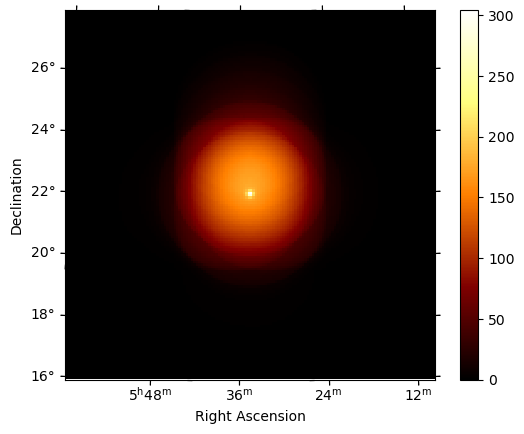

In [5]:
dataset_asimov.counts.sum_over_axes().plot(add_cbar=1)


<WCSAxesSubplot: >

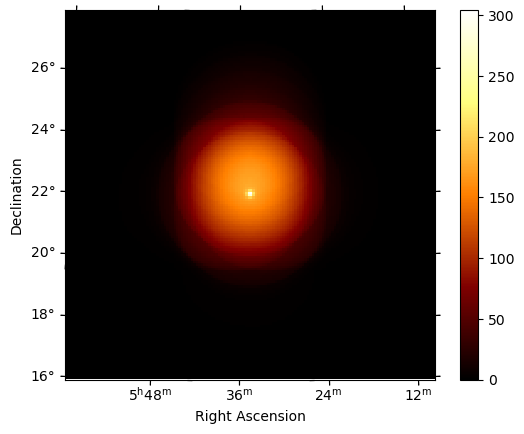

In [6]:
dataset_asimov.npred().sum_over_axes().plot(add_cbar=1)


The datasets counts and the datasets model prediction is now exactly the same. 
One can also plot the "significance". That is similar to a relative difference  between model and counts:
We expect this to be zero:

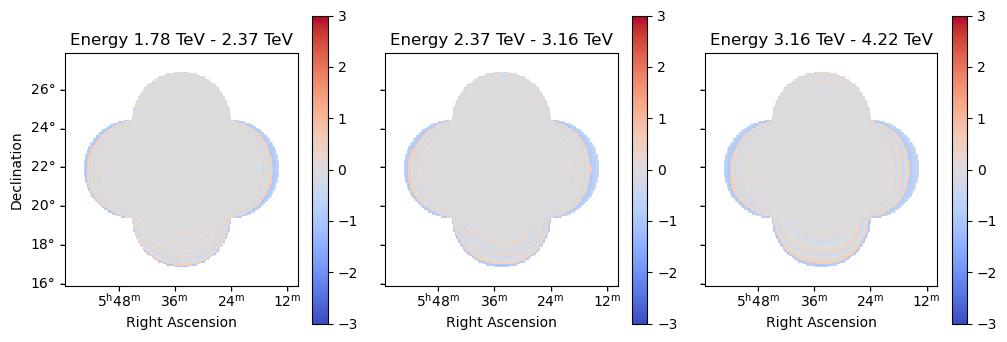

In [7]:
estimator = ExcessMapEstimator(
    correlation_radius=f"0.2 deg",
    energy_edges=dataset_asimov.counts.geom.axes['energy'].edges[10:14])
result = estimator.run(dataset_asimov)
vmax = 3
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-vmax, vmax=vmax,);

# Fitting the dataset

In [8]:
%%time
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_asimov])

CPU times: user 1.66 s, sys: 23.3 ms, total: 1.68 s
Wall time: 1.69 s


In [9]:
print(dataset_asimov)

MapDataset
----------

  Name                            : vbJMdI3x 

  Total counts                    : 361333 
  Total background counts         : 360331.31
  Total excess counts             : 1001.76

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753580.09

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : 1d-GYvu8
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
 

After the fit the parameters do not change, since we already describe the data perfectly. 


## Adding Statistical Fluctuations

In reality our data has statistical Fluctuations in it. This can also be simulated. 

In [10]:
# lets copy the dataset asimov again
dataset_stat = dataset_asimov.copy()
#now the counts are a possion draw of the model prediction
counts_data = np.random.poisson(dataset_asimov.npred().data)
dataset_stat.counts.data = counts_data
# since the models are not copied automatically, we again set them by hand:
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_stat.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_stat.models = models
print(dataset_stat)

MapDataset
----------

  Name                            : GlGgPTrM 

  Total counts                    : 360776 
  Total background counts         : 360331.31
  Total excess counts             : 444.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -751714.69

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : BATQMsrB
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
  

In [17]:
print(dataset_stat)

MapDataset
----------

  Name                            : GlGgPTrM 

  Total counts                    : 360776 
  Total background counts         : 360331.31
  Total excess counts             : 444.69

  Predicted counts                : 360777.23
  Predicted background counts     : 359793.27
  Predicted excess counts         : 983.96

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -751728.35

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : BATQMsrB
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
   

<WCSAxesSubplot: >

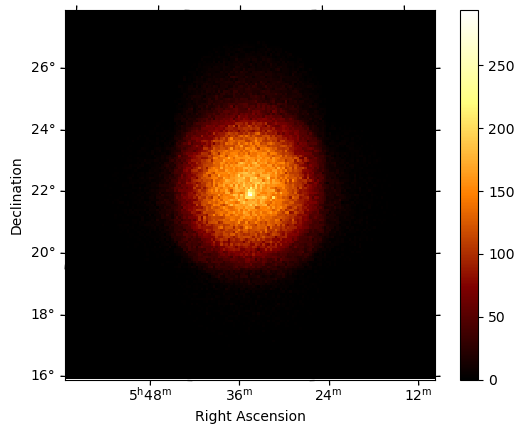

In [11]:
# now the counts are with random fluctuations
dataset_stat.counts.sum_over_axes().plot(add_cbar=1)


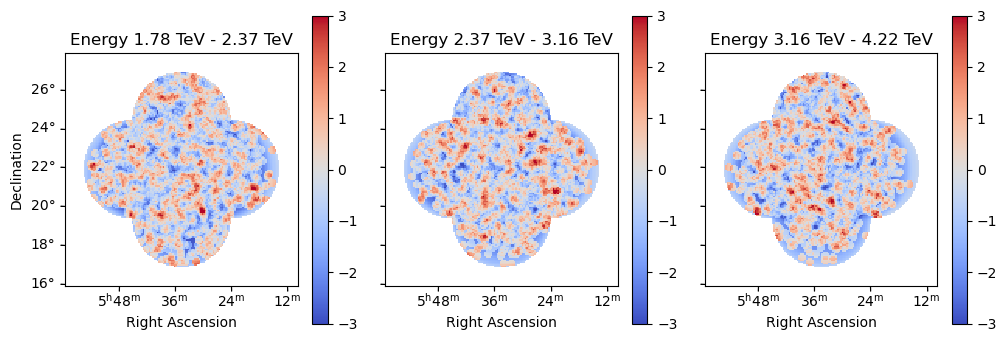

In [12]:
# the fluctuations can also be seen in the significance maps:
result = estimator.run(dataset_stat)
vmax = 3
result["sqrt_ts"].plot_grid(cmap="coolwarm", add_cbar=True, vmin=-vmax, vmax=vmax,);

In [13]:
%%time
fit_cor = Fit(store_trace=False)
result_cor = fit_cor.run([dataset_stat])

CPU times: user 4.47 s, sys: 38.5 ms, total: 4.51 s
Wall time: 4.5 s


In [14]:
result_cor

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 308
	total stat : -751728.35

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

In [15]:
print(dataset_stat)

MapDataset
----------

  Name                            : GlGgPTrM 

  Total counts                    : 360776 
  Total background counts         : 360331.31
  Total excess counts             : 444.69

  Predicted counts                : 360777.23
  Predicted background counts     : 359793.27
  Predicted excess counts         : 983.96

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -751728.35

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : BATQMsrB
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model type       : 
    Parameters:
   

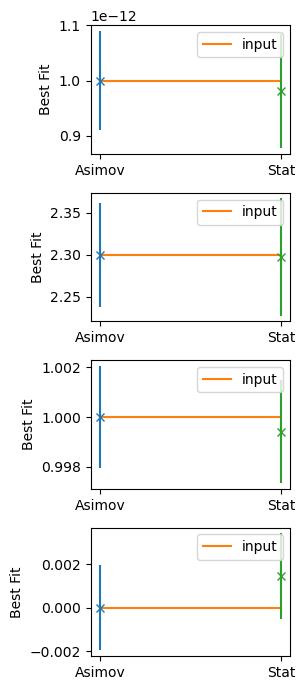

In [16]:
# comparin the best fit parameters of the asimov and the stat dataset
datasets = [dataset_asimov, dataset_stat]
parameters = ['amplitude', 'index', 'norm', 'tilt']

fig,axs = plt.subplots(len(parameters), 1,figsize = (3,7))
for j,  d in enumerate(datasets):
    for i, p in enumerate( parameters):
        axs[i].errorbar(0.1*j, d.models.parameters[p].value,
                       yerr = d.models.parameters[p].error, fmt= 'x', )
        if j ==0:
            axs[i].plot([0,0.1], [d.models.parameters[p].value] *2, label = 'input')
        
        
plt.tight_layout()
for a in axs:
    
    a.legend(); 
    a.set_ylabel('Best Fit'); 
    a.set_xticks([0,0.1],["Asimov", "Stat"])

The best-fit parmeters of the datset with the statistical fluctuations are a bit different from the input value.